<center><p style="font-size:30px">Quantum Circuits and Devices / Laboratory 2</p></center>
<center><p style="font-size:30px">Hardware qubit gates</p></center>

In [29]:
import sys
print(sys.executable)


/Users/baset/Documents/Academia/Qiskit/virtual_env_of_qiskit/bin/python3


## Table of Contents <a class="anchor" id="table-of-contents"></a>

1. [Time-continuous qubit simulation](#time-continuous-simulation)
2. [Pulse-level qubit simulation](#pulse-level)
3. [Calibrating a Rabi pulse](#rabi-pulse)
4. [Detuning](#detuning)

In this laboratory, we will introduce the Qiskit Dynamics extension to perform continuous-time simulation of quantum circuits. Depending on the environment, the `qiskit-dynamics` extension may not be installed. Run the following cell to install it:

### Requirements

In [30]:
# %pip install qiskit==1.2.4 qiskit-ibm-runtime qiskit_aer qiskit-dynamics==0.5.1
# %pip install matplotlib pylatexenc seaborn

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter  
from qiskit.quantum_info import Operator, Statevector
from qiskit_dynamics import Solver, Signal, DynamicsBackend
from qiskit_dynamics.pulse import InstructionToSignals
from qiskit.visualization import plot_histogram
from qiskit.visualization.bloch import Bloch
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython import display
import qiskit.pulse as pulse

X = Operator.from_label('X'); 
Y = Operator.from_label('Y'); 
Z = Operator.from_label('Z'); 
I = Operator.from_label('I');

def get_meas_signal(results,n,nshots):
    values = []
    for i in range(n):
        try:
            p1 = results.get_counts(i)['1'];
        except KeyError:
            p1 = 0; 
        values.append(p1/nshots);
    return values; 

def video_bloch_traj(y,mod=1):
    for i in range(len(y)):
        if np.mod(i,mod) != 0:
                continue;
        try:
            display.display(y[i].draw("bloch"))
            display.clear_output(wait=True)
            time.sleep(0.001)
        except KeyboardInterrupt:
            break

def plot_bloch_traj(states,mod=1):
    from qiskit.visualization.bloch import Bloch
    from qiskit.quantum_info import Operator
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    X = Operator.from_label('X'); 
    Y = Operator.from_label('Y'); 
    Z = Operator.from_label('Z'); 

    cmap = mpl.colormaps["winter"]
    blues = cmap(np.linspace(0,1,int(np.ceil(len(states)/mod))));
    bls = [];
    for i in range(len(blues)):
        bls.append(mpl.colors.rgb2hex(blues[i]));
    blues = bls; 

    _bloch = Bloch()
    _bloch.point_marker = ['o']
    _bloch.point_color = blues; 

    for i in range(len(states)):
        if np.mod(i,mod) != 0:
            continue;
        _bloch.add_points([states[i].expectation_value(X).real, states[i].expectation_value(Y).real, states[i].expectation_value(Z).real])
    
    _bloch.render(); 

def plot_qubit_dynamics(sol, t_eval):
    from qiskit.quantum_info import Operator
    
    X = Operator.from_label('X');
    Y = Operator.from_label('Y');
    Z = Operator.from_label('Z');

    n_times = len(sol.y)
    x_data = np.zeros((n_times,))
    y_data = np.zeros((n_times,))
    z_data = np.zeros((n_times,))

    for t_i, sol_t in enumerate(sol.y):
        x_data[t_i] = sol_t.expectation_value(X).real
        y_data[t_i] = sol_t.expectation_value(Y).real
        z_data[t_i] = sol_t.expectation_value(Z).real

    _, ax = plt.subplots(figsize = (20, 6))
    fontsize = 16;
    plt.rcParams.update({'font.size': fontsize})
    plt.plot(t_eval/1e-9, x_data, label = '$\\langle X \\rangle$')
    plt.plot(t_eval/1e-9, y_data, label = '$\\langle Y \\rangle$')
    plt.plot(t_eval/1e-9, z_data, label = '$\\langle Z \\rangle$')
    plt.legend(fontsize = fontsize)
    ax.set_xlabel('$t$ [ns]', fontsize = fontsize)
    ax.set_title('Bloch vector vs. $t$', fontsize = fontsize)
    plt.show()

def fit_function(x_values, y_values, function, init_params):
    from scipy.optimize import curve_fit
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    return fitparams, y_fit

def plot_populations(sol,tend):
    pop0 = [psi.probabilities()[0] for psi in sol.y]
    pop1 = [psi.probabilities()[1] for psi in sol.y]

    fig = plt.figure(figsize=(8, 5))
    plt.plot(sol.t, pop0, lw=3, label="Population in |0>")
    plt.plot(sol.t, pop1, lw=3, label="Population in |1>")
    plt.xlabel("Time (ns)")
    plt.ylabel("Population")
    plt.legend(frameon=False)
    plt.ylim([0, 1.05])
    plt.xlim([0, tend])
    plt.vlines(tend, 0, 1.05, "k", linestyle="dashed")

## Time-continuous qubit simulation <a class="anchor" id="time-continuous-simulation"></a>

Qiskit Dynamics is an extension of the Qiskit framework providing pulse-level simulation capability. The first step is to define a model for our quantum system in terms of its Hamiltonian. As a typical example, we consider a two-level quantum system with a natural frequency $\omega$, subject to a resonant drive Hamiltonian, 

\begin{align}\hat{H} = \frac12 \omega \hat{\sigma}_z + \Omega \cos(\omega t)\hat{\sigma}_x\end{align}

This Hamiltonian could describe, for example, a spin-qubit system subject to a constant magnetic field in the $z$-direction, and an oscillating magnetic field in the $x$-direction. In the case of superconducting qubits such as transmon qubits, the $\hat{\sigma_z}$ part of the Hamiltonian is given by the oscillation of the $\{|g\rangle,|e\rangle\}$ doublet, and the $\hat{\sigma_x}$ part is instead given by the EM drive field. 

### Solver setup

The first step for the continuous-time simulation is to setup an object of the `Solver` class, which contains all the information about the system model. The `Solver` constructor requires us to specify the `static_hamiltonian`, corresponding to the qubit's natural Hamiltonian, and the `hamiltonian_operators` corresponding to the interaction Hamiltonians in presence of a driving field. We assume a qubit frequency $\omega = 2\pi \cdot 4.95 \text{GHz}$, and a Rabi frequency of $\Omega = 2\pi \cdot 20 \text{MHz}$. 

In [31]:
#########################################
# System specifications
#########################################
omega = 2 * np.pi * 4.95e9;                 # Qubit pulsation [rad/s]
Omega = 2 * np.pi * 20e6;                   # Rabi pulsation at maximum drive [rad/s]

hdrift = 1/2 * omega * Z;                   # Natural Hamiltonian (precession)
hdrive = Omega * X;                         # Interaction Hamiltonian (driving field)

solver = Solver(static_hamiltonian=hdrift, hamiltonian_operators=[hdrive]);
print(omega / 2 / np.pi)

4950000000.0


Next, we must define the electric or magnetic signals applied to our qubit, for which we use the `Signal` class. In most quantum computing systems based on superconducting qubits, the driving signal is typically realized by mixing together a microwave tone (the carrier) with a modulating signal (the envelope):

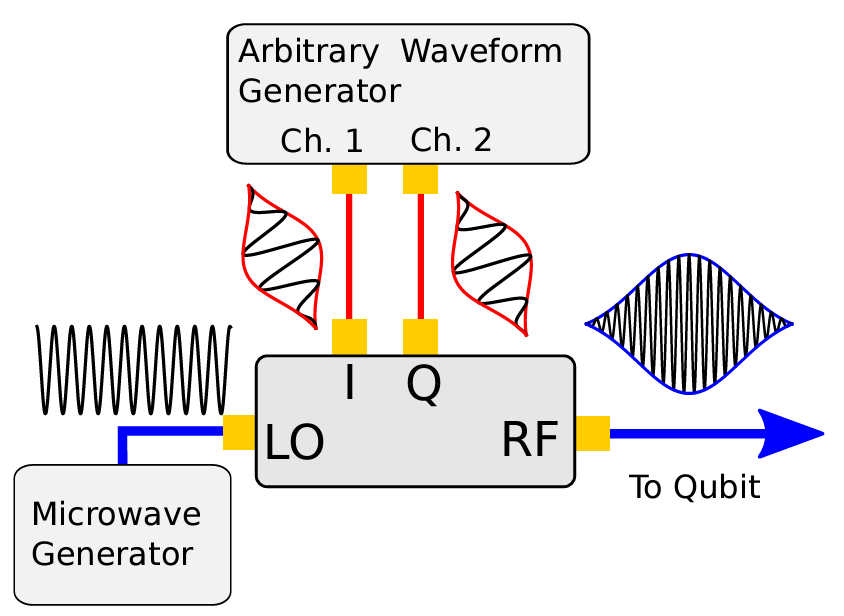
<center>
<i>Fig. 1. Schematic of the typical experimental setup for generating shaped microwave pulses for driving superconducting qubits. Reproduced with permission from <a href="https://arxiv.org/abs/1612.00858">D. McKay, et al., 2017</a></i>.</center>

The arbitrary waveform generator (AWG) has two output channels $A_1$ and $A_2$ which are sent to the in-phase (I) and in-quadrature (Q) inputs of the mixer, resulting in an output signal: 

\begin{align}
RF(t) = A_1(t)\cos(\omega t) + A_2(t)\cos(\omega t + \frac{\pi}{2}) = A_1(t)\cos(\omega t) + A_2(t)\sin(\omega t) = I(t) \cos(\omega t) + Q(t) \sin(\omega t)
\end{align}

By appropriately choosing waveforms for the $I(t)$ and $Q(t)$ inputs, we can turn on or off the driving field and consequently act on the qubit state. Notice that the carrier signal is always running, and the setup is typically calibrated in order for the qubit and carrier to share the same frequency $\omega$. In this way, independently of when we "enable" the field (by sending a suitable modulation signal to the mixer), the driving field will always be synchronized with the qubit. 

### Signal class

The most basic `Signal` constructor requires us to specify the carrier frequency of the signal (corresponding to the frequency of our cosinusoidal pulse) via `carrier_freq`, and the shape of the signal's envelope via the `envelope` kwarg. We can plot the obtained signal by using the `.draw(ts,te,n)` method, where `ts, te, n` are the start time, end time, and number of samples respectively. As a first example, let us consider a constant envelope for our `Signal`:

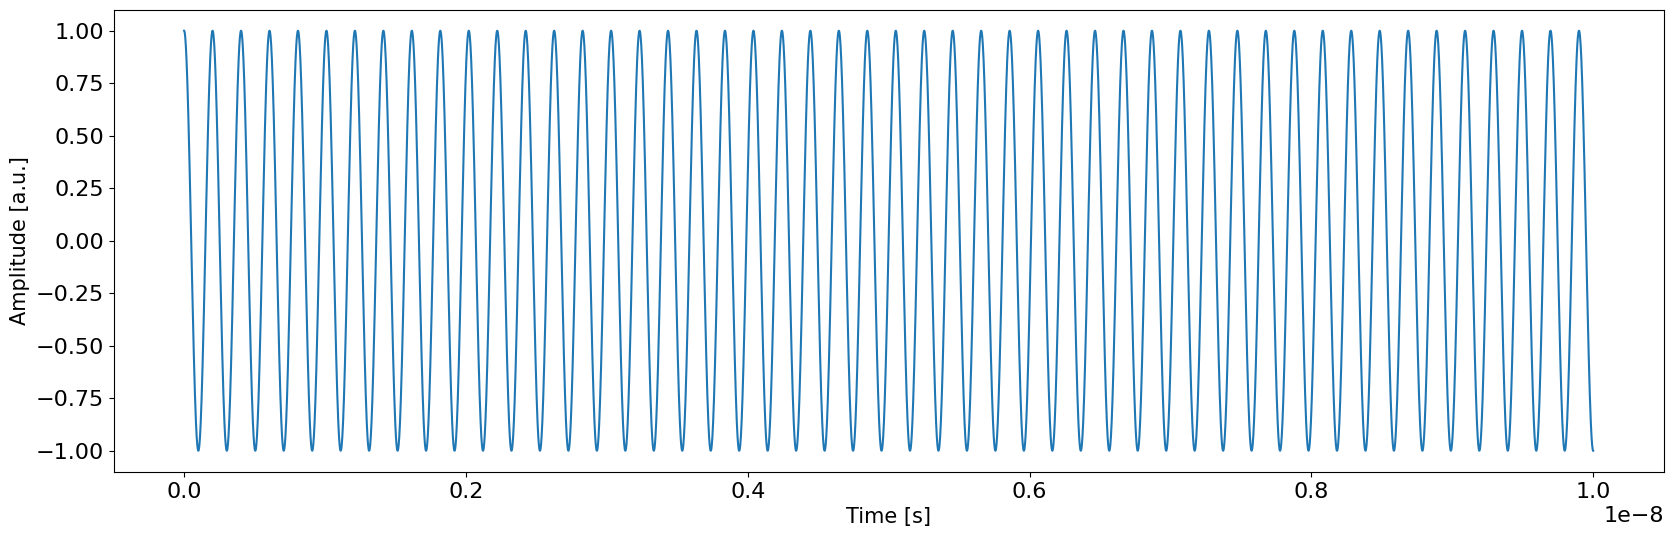

In [32]:
#########################################
# Signal creation
#########################################
signal = Signal(envelope=1,carrier_freq= omega / 2 / np.pi);

#########################################
# Graphics
#########################################
ax = signal.draw(0,10e-9,10000)
plt.gcf().set_size_inches(20,6)
plt.xlabel('Time [s]',fontsize=15);
plt.ylabel('Amplitude [a.u.]',fontsize=15);

Notice that the amplitude of the drive signal is actually linked to the Rabi frequency we specified in the `Solver` definition. An amplitude of `1` will correspond to a driving Hamiltonian of strength $\Omega$, a drive of amplitude `0.5` to a driving Hamiltonian of strength $\Omega$ (and thus to an effective Rabi frequency of $\Omega$), and so on. 

The `envelope` can also be a `Callable` object, such as a `lambda` function (a Python equivalent of Matlab's `function_handle`). Let's assume we are interested in performing a $\pi/2$ pulse, which thus requires us to operate the driving field for a time $t = \frac{\pi}{2\Omega}$.

Gate time: 12.50 ns


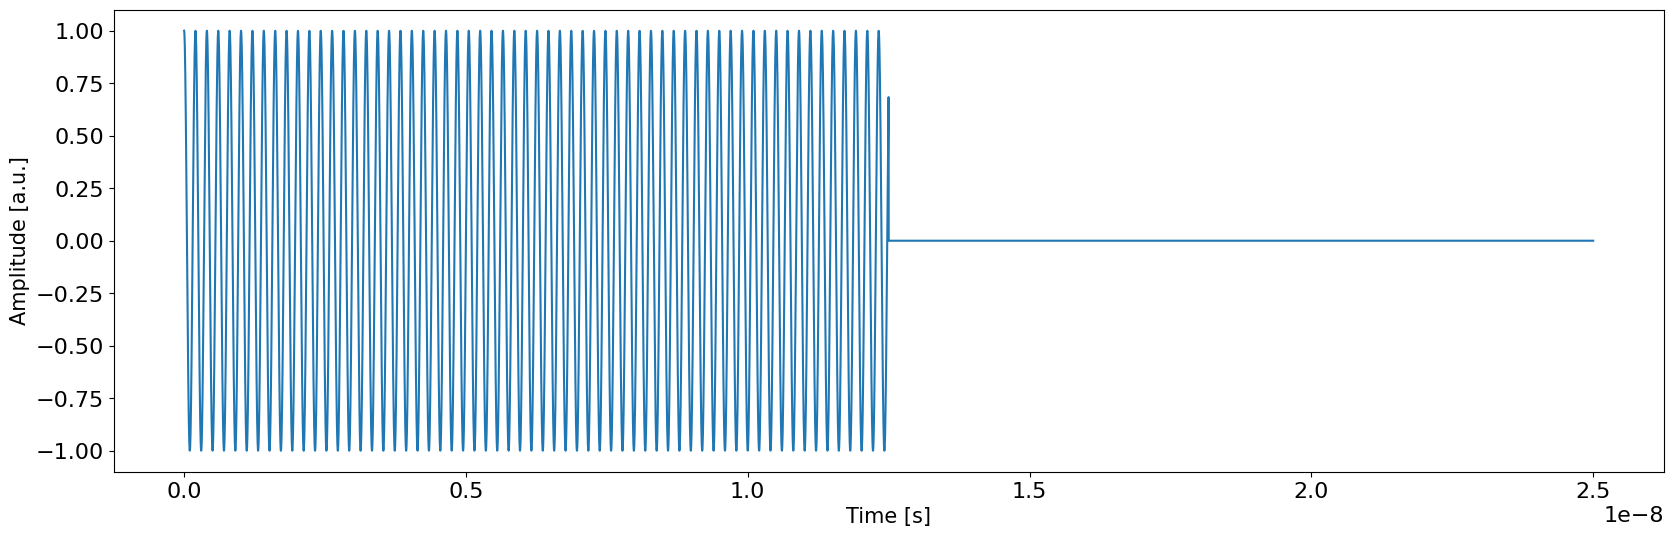

In [33]:
#########################################
# Signal creation
#########################################
tgate   = np.pi / (2*Omega);                   # Gate time
envfunc = lambda t : 1. * (t <= tgate) + 0. * (t > tgate);          # Envelope function (rect)
signal  = Signal(envelope=envfunc,carrier_freq=omega/2/np.pi);      # Signal object

#########################################
# Graphics
#########################################
print(f"Gate time: {tgate/1e-9:.2f} ns"); 
signal.draw(0,25e-9,12000)
plt.gcf().set_size_inches(20,6)
plt.xlabel('Time [s]',fontsize=15);
plt.ylabel('Amplitude [a.u.]',fontsize=15);

### Time-domain simulation

We can finally simulate our system with the `.solve()` method of the `Solver` class. Required arguments are: 
* `t_span`, setting the start and end time for the simulation, 
* `y0`, setting the initial state of the qubit (a `Statevector` instance)
* `signals`, a `list` of applied EM signals, 
* `t_eval`, an array of specific times at which the solution must be evaluated. 

We assume the qubit to be initialized in the $|0\rangle$ state, and simulate up to a time $1.5 t_{\pi/2}$. 

In [34]:
#########################################
# Simulation setup
#########################################
tend = 1.5 * tgate;                         # Simulation time 
t_eval = np.linspace(0,tend,20000);         # Simulation time points
y0 = Statevector.from_label('0');           # Initial state (|0>)

sol = solver.solve(t_span=[0,tend],y0=y0,signals=[signal],t_eval=t_eval);

The output of `.solve()` is a list of `Statevector`s representing our qubit at each of the time instants defined by `t_eval`. We can see the Rabi driving in action:

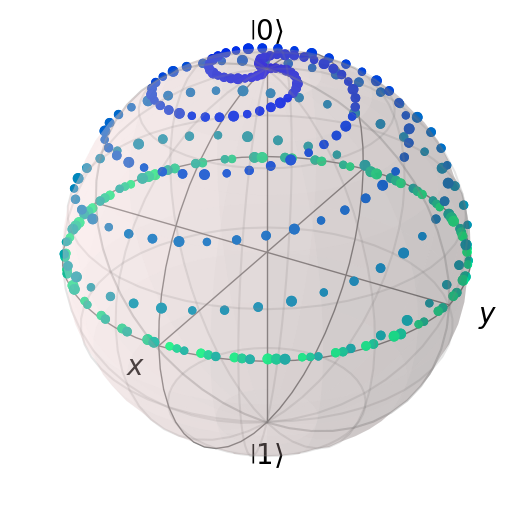

In [35]:
# video_bloch_traj(sol.y,30)
plot_bloch_traj(sol.y,70)

Let's check the state of our qubit at the end of the gate pulse. The precession around the $z$-axis due to the static Hamiltonian leads to a phase accumulation of $\phi = \omega t = 2\pi \text{4.95 GHz} \cdot \text{12.5 ns} = \frac34 \pi$. 

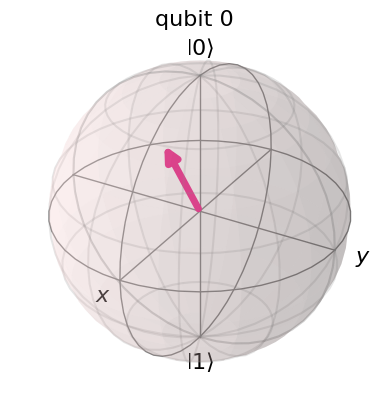

In [36]:
ngate = int(np.ceil(tgate/ np.diff(t_eval)[0]));
sol.y[ngate].draw("bloch")

Perhaps a better way to visualize the state dynamics is to plot the expectation value of the $X, Y, Z$ operators, corresponding to the components of the qubit state on the $xyz$ axes. To this aim, we define the following helper function: 

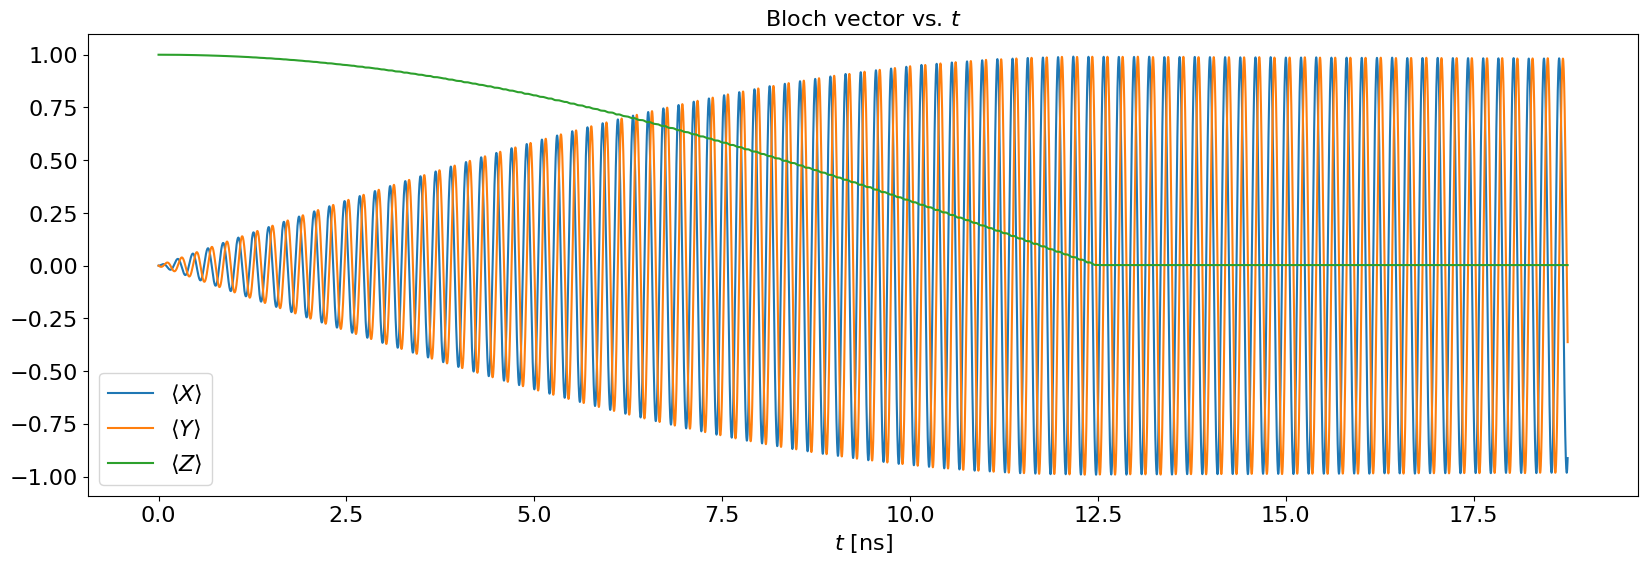

In [37]:
plot_qubit_dynamics(sol,t_eval)

Notice how the state shows the signs of the $z$-precession, which are traceable in the oscillation of the $\langle X\rangle$ and $\langle Y\rangle$ expectation values. Conversely, the $\langle Z \rangle$ component highlights the $\pi/2$ rotation of the state vector.  

### Rotating frame

The performance of the `Solver` class can be further improved by providing a `rotating_frame` Hamiltonian, which also provides a clearer picture of the rotation enacted on the qubit. Since we have by now understood that the cosinusoidal drive and the qubit frequency are synchronized in our setup, we no longer have to worry about tracking the qubit phase to time the execution of gates. When passing a `rotating_frame` Hamiltonian to the `Solver` class, the rotating Hamiltonian is subtracted from the system's Hamiltonian. As a first example, we consider the frame to be rotating at the same frequency of the qubit and the drive: 

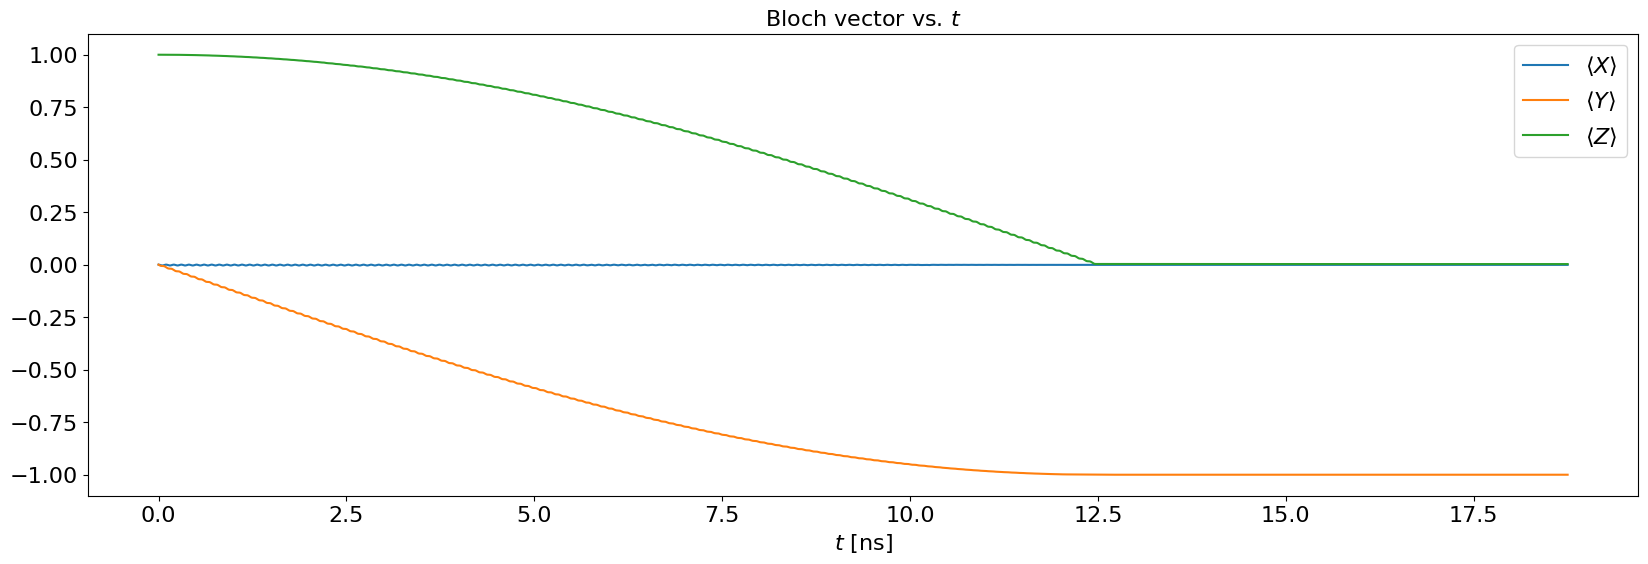

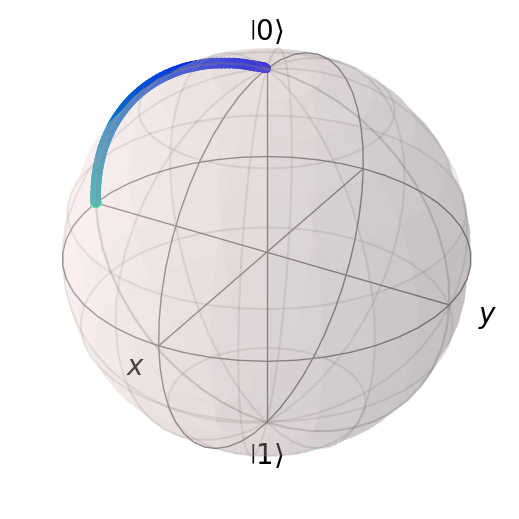

In [38]:
#########################################
# Simulation (w/o rotating frame)
#########################################
solver = Solver(static_hamiltonian=hdrift, hamiltonian_operators=[hdrive], rotating_frame=hdrift);
sol = solver.solve(t_span=[0,tend],y0=y0,signals=[signal],t_eval=t_eval);
plot_qubit_dynamics(sol,t_eval)
plot_bloch_traj(sol.y,50)

### Driving phase

What if we want to operate a rotation around $y$? We just need to specify an imaginary envelope for the pulse, which will correspond to using the second output channel, _i.e._ the _quadrature_ output, of the AWG in the previous figure. As an example, let us simulate the same pulse with an imaginary amplitude, which should correspond to a $\pi/2$ rotation around $y$. 

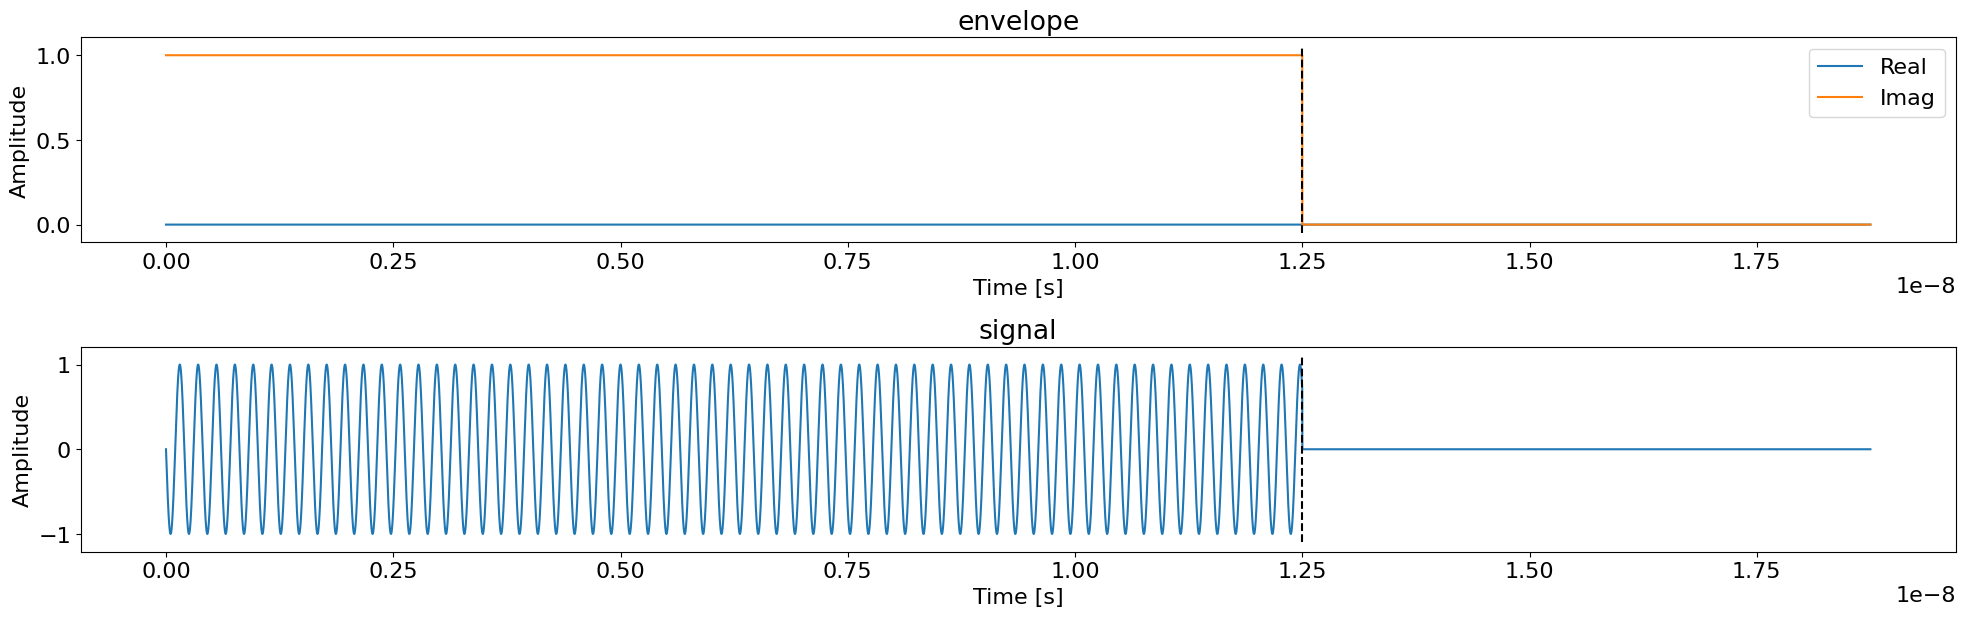

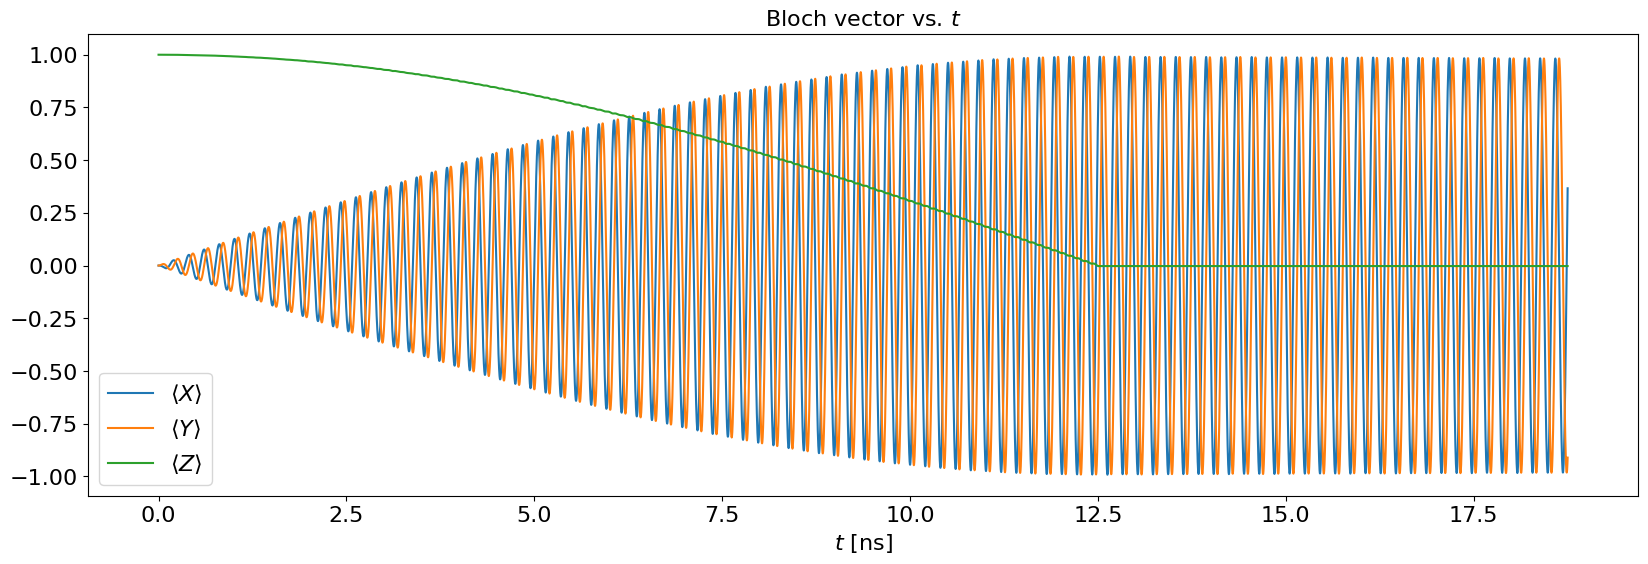

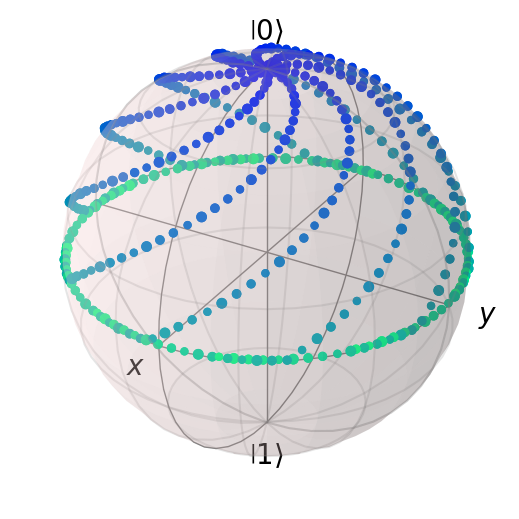

In [39]:
#########################################
# Signal creation
#########################################
tgate   = np.pi / (2*Omega);                   # Gate time
envfunc = lambda t : 1j * (t <= tgate) + 0. * (t > tgate);          # Envelope function (rect)
signal  = Signal(envelope=envfunc,carrier_freq=omega/2/np.pi);      # Signal object

#########################################
# Signal Graphics
#########################################
fig, axs = plt.subplots(2, 1, figsize=(20, 6))
fig.tight_layout(h_pad=3)
for ax, title in zip(axs, ["envelope", "signal"]):
    signal.draw(0, tend, 50000, title, axis=ax)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Amplitude")
    ax.set_title(title)
    ax.vlines(tgate, ax.get_ylim()[0], ax.get_ylim()[1], "k", linestyle="dashed")

#########################################
# Simulation setup
#########################################
tend = 1.5 * tgate;                         # Simulation time 
t_eval = np.linspace(0,tend,21000);         # Simulation time points
y0 = Statevector.from_label('0');           # Initial state (|0>)

#########################################
# Simulation (w/o rotating frame)
#########################################
solver = Solver(static_hamiltonian=hdrift, hamiltonian_operators=[hdrive]);
sol = solver.solve(t_span=[0,tend],y0=y0,signals=[signal],t_eval=t_eval);
plot_qubit_dynamics(sol,t_eval)
plot_bloch_traj(sol.y,50)
#video_bloch_traj(sol.y,30); 

We can use a rotating frame to get a clearer picture of the $y$-rotation:

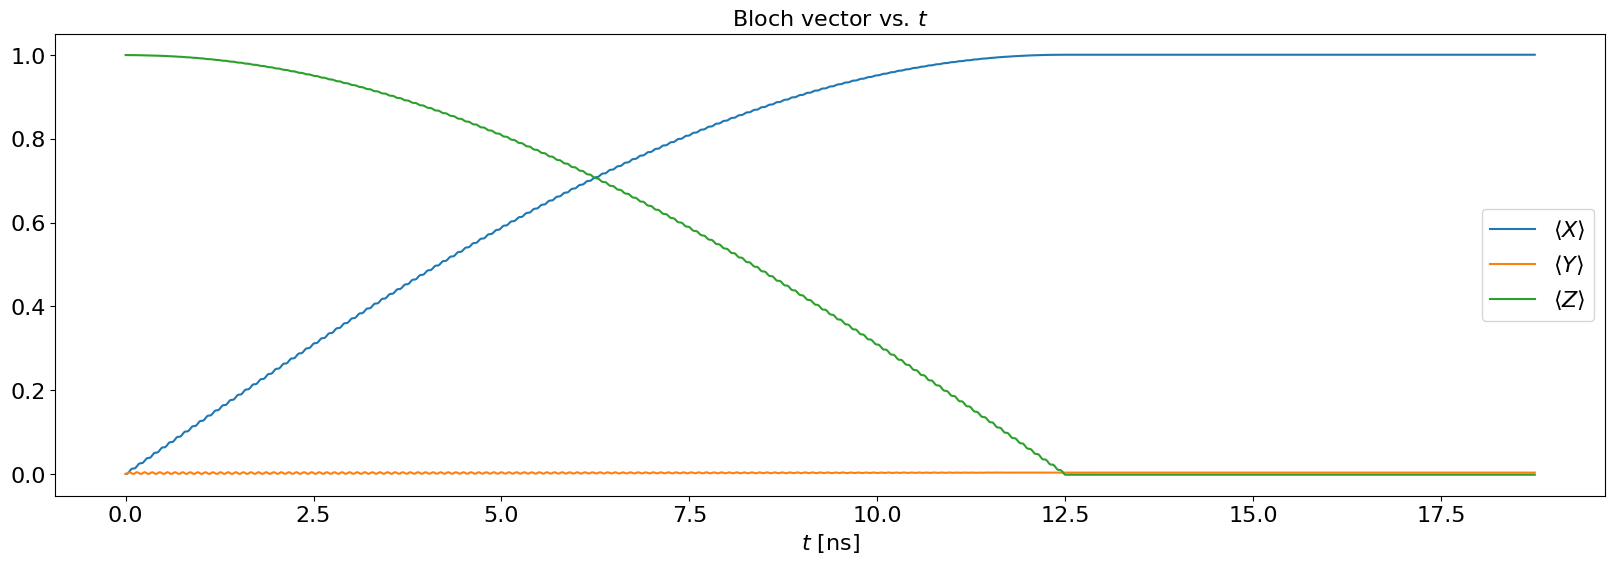

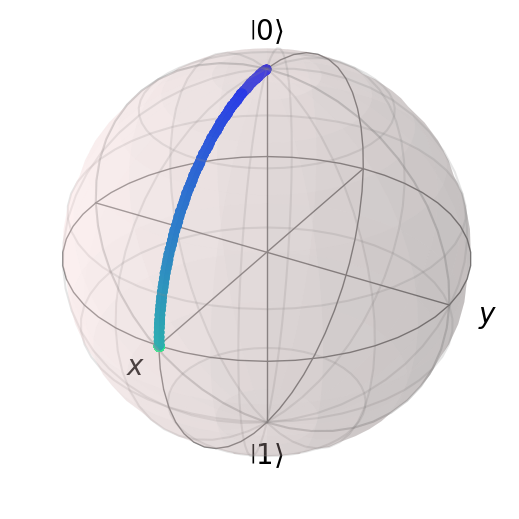

In [40]:
#########################################
# Simulation (w/ rotating frame)
#########################################
solver = Solver(static_hamiltonian=hdrift, hamiltonian_operators=[hdrive], rotating_frame=hdrift);
sol = solver.solve(t_span=[0,tend],y0=y0,signals=[signal],t_eval=t_eval);
plot_qubit_dynamics(sol,t_eval)
plot_bloch_traj(sol.y,50)
#video_bloch_traj(sol.y,50); 

### Multiple pulses

If we wish to simulate multiple pulses, we just need to generate an envelope function accordingly. For example, let's simulate two $\pi$-rotations around $x$, separated by a 10 ns idle time. 

Gate time: 12.50 ns
Idle time: 10.00 ns


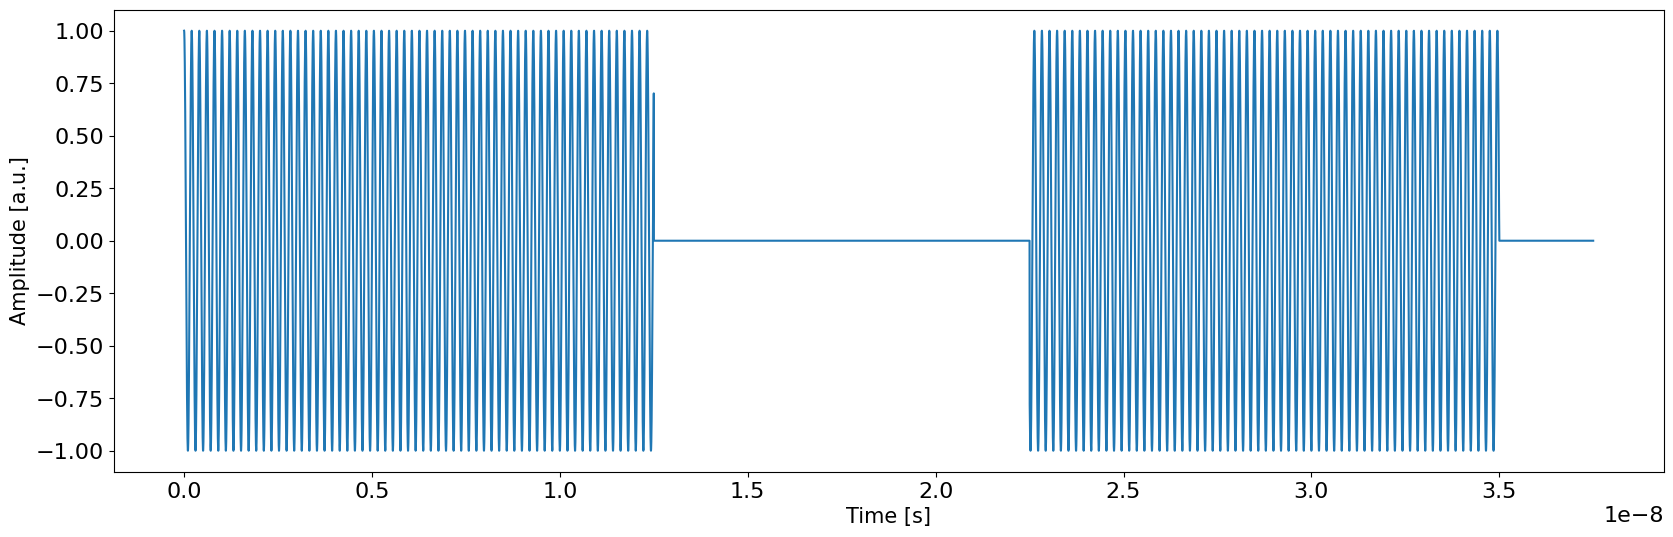

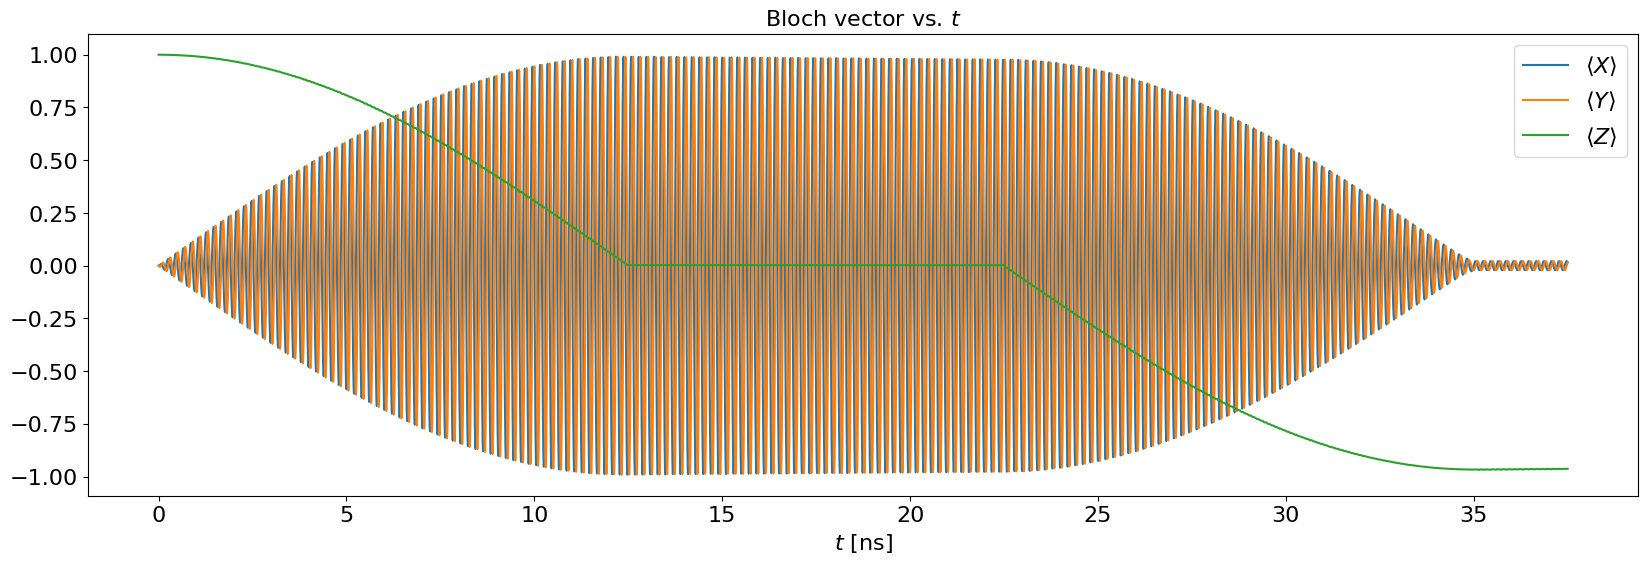

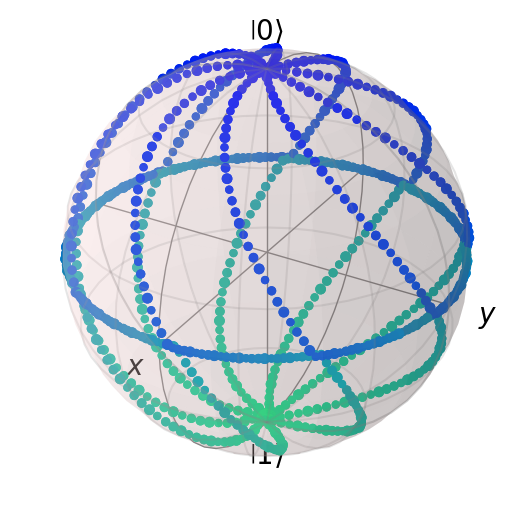

In [41]:
#########################################
# Simulation setup
#########################################
tidle   = 10e-9;                                                                                        # Idle time between pulses
envfunc = lambda t : 1. * ((t <= tgate) | ( (t >= (tgate + tidle)) & (t <= tgate + tidle + tgate)));    # Envelope function (double rect)
signal  = Signal(envelope=envfunc,carrier_freq=omega/2/np.pi);                                          # Signal object
tend    = 3 * tgate;                                                                                    # Simulation end time
t_eval  = np.linspace(0,tend,50000);                                                                    # Simulation time points

#########################################
# Graphics
#########################################
print(f"Gate time: {tgate/1e-9:.2f} ns"); 
print(f"Idle time: {tidle/1e-9:.2f} ns"); 
signal.draw(0,tend,50000)
plt.gcf().set_size_inches(20,6)
plt.xlabel('Time [s]',fontsize=15);
plt.ylabel('Amplitude [a.u.]',fontsize=15);

#########################################
# Simulation (w/o rotating frame)
#########################################
solver = Solver(static_hamiltonian=hdrift, hamiltonian_operators=[hdrive]);
sol = solver.solve(t_span=[0,tend],y0=y0,signals=[signal],t_eval=t_eval);
plot_qubit_dynamics(sol,t_eval)
plot_bloch_traj(sol.y,60)
#video_bloch_traj(sol.y,30)


Again, a rotating frame helps us better understand the overall net rotation enacted on the qubit: 

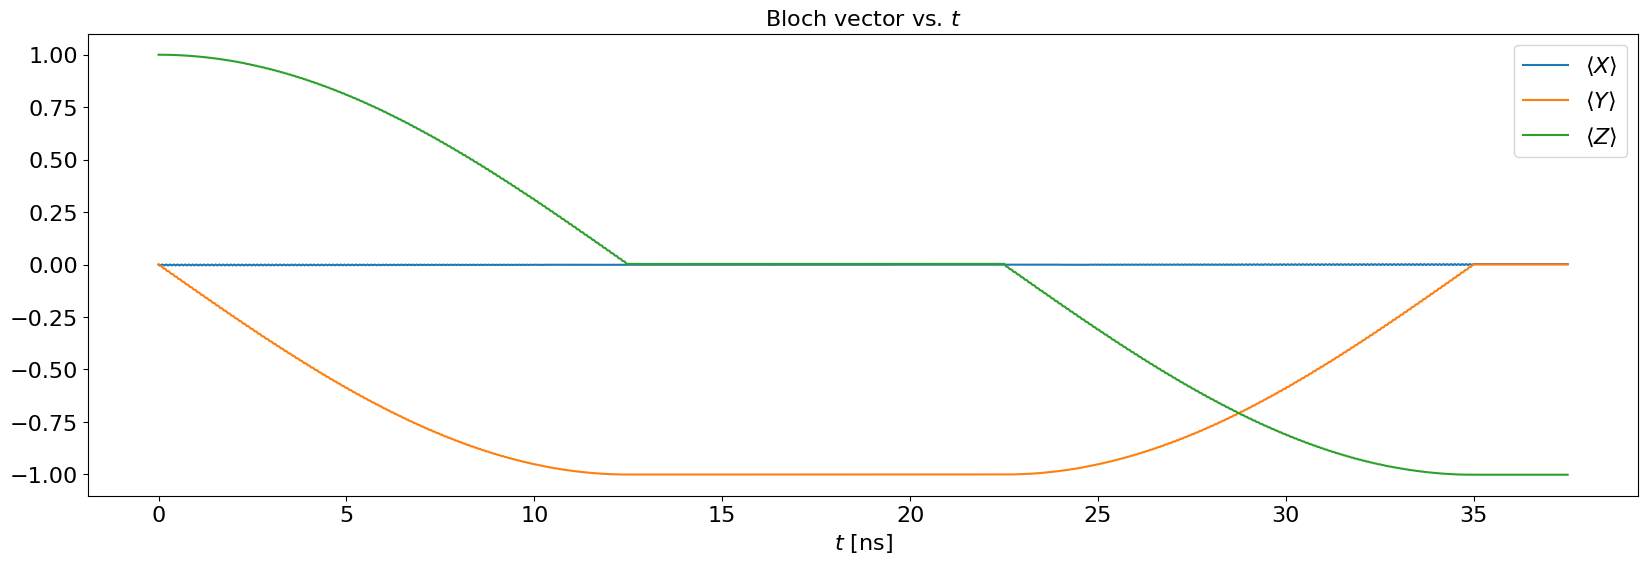

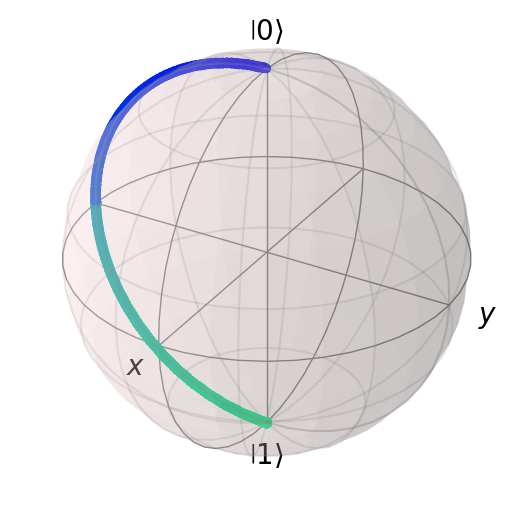

In [42]:
#########################################
# Simulation (w/ rotating frame)
#########################################
solver = Solver(static_hamiltonian=hdrift, hamiltonian_operators=[hdrive], rotating_frame=hdrift);
sol = solver.solve(t_span=[0,tend],y0=y0,signals=[signal],t_eval=t_eval);
plot_qubit_dynamics(sol,t_eval)
plot_bloch_traj(sol.y,60)

Notice how, thanks to this experimental setup, the qubit correctly rotates twice around the $x$ axis of an angle $\pi/2$, despite the state having accumulated an overall azimutal phase of $\omega(t_{gate}+t_{idle}) = \pi/2$. Again, this is due to the carrier frequency constantly running "in the background", thus equivalently keeping track of the qubit phase. Think of the experimental setup as follows: the cosinusoidal signal and the qubit are placed next to each other and separated by a rolling shutter. At any time, the cosinusoidal signal behind the rolling shutter is cycling back and forth at the same frequency at which the qubit rotates around the $z$-axis. When we want to perform a rotation around the $x$-axis, we open the rolling shutter and let the qubit and field "see" each other, _i.e._ interact. We keep the rolling shutter open for the desired time, and then close it, turning off the interaction. Now, behind the shutter, the field is still cycling back and forth at the same frequency, and on the other side the qubit is rotating around the $z$-axis again at the same frequency: the two oscillations are still synchronized. Independently of when we open the shutter again, there will still be the same phase relation between the cosinusoidal drive and the qubit, and therefore we will still be operating a rotation around the same $x$-axis.

## Pulse-level qubit simulation <a class="anchor" id="pulse-level"></a>

Signal-level simulation is extremely close to the hardware layer. On the other hand, gate-level simulation as shown in the first laboratory is closer to the algorithm-level, and thus to a way higher level of abstraction. Pulse-level simulation locates inbetween signal-level and gate-level, providing a viable intermediate allowing for concatenating operations similarly to gate-level simulation, while keeping an eye on the hardware as in signal-level simulation. In Qiskit, a `Pulse` is the generic representation of a pulsed interaction between the driving field and the qubit state. 

### Pulse schedules

`Pulse` `Schedule`s allow, as the name suggest, to define a schedule of pulses to be applied to a given qubit. `Schedule`s must be built using an appropriate context manager, which is invoked using the Python keyword `with`, followed by the context initializer `pulse.build()` and by the variable where the pulse schedule will be stored prepended by the keyword `as`. 

An alignment strategy must then be defined. The most typical is sequential alignment, _i.e._ each pulse is added after the previous ones, which is invoked using the keyword `with` followed by `pulse.align_sequential()`. 

Inside the context manager, `Pulse`s can be added to the schedule using the `.play(pulse,channel)` method. The `pulse` argument specifies the type of `Pulse` to add: when operating at the pulse-level, this equals the envelope of the signal. All `Pulses` are characterized by a `duration` which is expressed in terms of the number of samples at the system's time resolution `dt`, corresponding to the inverse of the bandwidth of our AWG. Typical values for AWG bandwidths are in the order of 4-5 GHz for most superconducting quantum computing systems.

The most common types of `Pulse`, found in the `pulse.library` module, are:
* `constant(duration,amp)`: a constant envelope of amplitude `amp` and duration `duration`. This is analogous to the rectangular envelope we used in the preceding section of this Laboratory.
* `gaussian(duration, amp, sigma)`: a Gaussian envelope of amplitude `amp`, standard deviation `sigma`, and duration `duration`. Gaussian envelopes help reducing the spectral broadening of the pulse, preventing excitation of higher-level transitions. 
* `drag(duration, amp, sigma, beta)`: a DRAG (Derivative Removal by Adiabatic Gate) envelope. DRAG pulses are realized by superimposing an in-phase Gaussian pulse with amplitude `amp`, standard deviation `sigma`, and duration `duration`, to an in-quadrature Gaussian derivative pulse with the same size as the in-phase component, scaled by `beta`. DRAG pulses further improve the spectral characteristic of the pulse by introducing a notch in the pulse spectrum at the frequency corresponding to one higher-level transition, effectively suppressing the possibility of leakage to higher states. 

The carrier frequency will instead be provided by the driving channel, which is specified using the `channel` argument. When acting on qubits to manipulate their state, `DriveChannel` objects represent driving lines of the qubit. The index of the `DriveChannel` typically corresponds to the index of the corresponding qubit, as each qubit typically has its own drive line. 

Additional useful instructions to build the `Schedule` are:
* `pulse.shift_phase(phi,channel)`: shifts the phase of the carrier signal in `channel` by `phi`. Depending on the underlying hardware implementation and on the angle `phi`, this task may be accomplished in many different ways. For example, in a setup using a two-channel AWG per drive line, a $\pi/2$ phase shift may be introduced by simply switching to use the $Q(t)$ output instead of the $I(t)$ output for the following pulses. For arbitrary `phi` values, this may be realized by changing the bias of a phase detector driven by the carrier frequency. Irrespectively of the hardware implementation, we can assume that after this instructions, the carrier frequency will have shifted by exactly the phase `phi`. 
* `pulse.delay(duration,channel)`: idles the `channel` for a time `duration`.  

Let us build the `Schedule` corresponding to our last signal-level setup, _i.e._ a $\pi/4$ $y$-rotation (carrier phase shift by $\pi/2$ followed by a constant pulse of 6.25 ns), idling time of 10 ns, and a $\pi/4$ $x$-rotation (carrier phase shift by $-\pi/2$ followed by a constant pulse of 6.25 ns). We assume our AWG to have a time-resolution `dt` of 1/4.5 GHz. 

4950000000.0


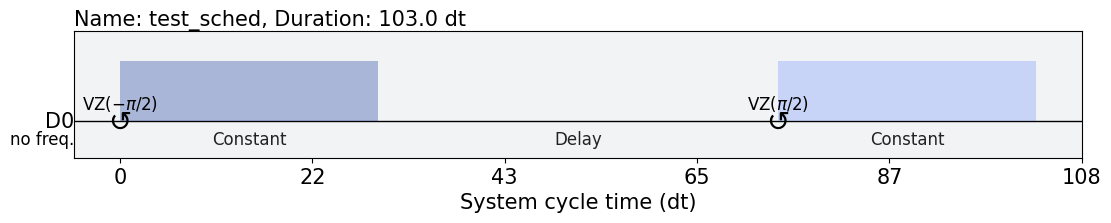

In [46]:
#########################################
# System specifications
#########################################
omega = 2 * np.pi * 4.95e9;                 # Qubit pulsation [rad/s]
Omega = 2 * np.pi * 20e6;                   # Rabi pulsation at maximum drive [rad/s]

hdrift = 1/2 * omega * Z;                   # Natural Hamiltonian (precession)
hdrive = Omega * X;                         # Interaction Hamiltonian (driving field)

solver = Solver(static_hamiltonian=hdrift, hamiltonian_operators=[hdrive]);
print(omega / 2 / np.pi)

tgate = np.pi/4/Omega;                      # Time for pi/4 gate
tidle = 10e-9;                              # Idling time between pulses

#########################################
# Schedule setup
#########################################
dt = 1/4.5e9;                               # AWG time resolution
dgate = int(np.ceil(tgate/dt));             # Gate duration [cycles]
didle = int(np.ceil(tidle/dt));             # Idle duration [cycles]

#########################################
# Schedule creation
#########################################
with pulse.build(name="test_sched") as sxp:
    with pulse.align_sequential():
        pulse.shift_phase(np.pi/2, pulse.DriveChannel(0))
        pulse.play(pulse.library.Constant(dgate,1), pulse.DriveChannel(0))
        pulse.delay(didle,pulse.DriveChannel(0))
        pulse.shift_phase(-np.pi/2, pulse.DriveChannel(0))
        pulse.play(pulse.library.Constant(dgate,1), pulse.DriveChannel(0))

#########################################
# Graphics
#########################################
sxp.draw()

### Pulse to Signal conversion

`Schedule` objects can be converted back to `Signal` objects using the `InstructionToSignals` function of the `qiskit_dynamics.pulse` module. For each of the `DriveChannel`s used in the `Schedule`, we must specify the corresponding carrier frequency using the `carriers` kwarg and a `dict`. 

146.25

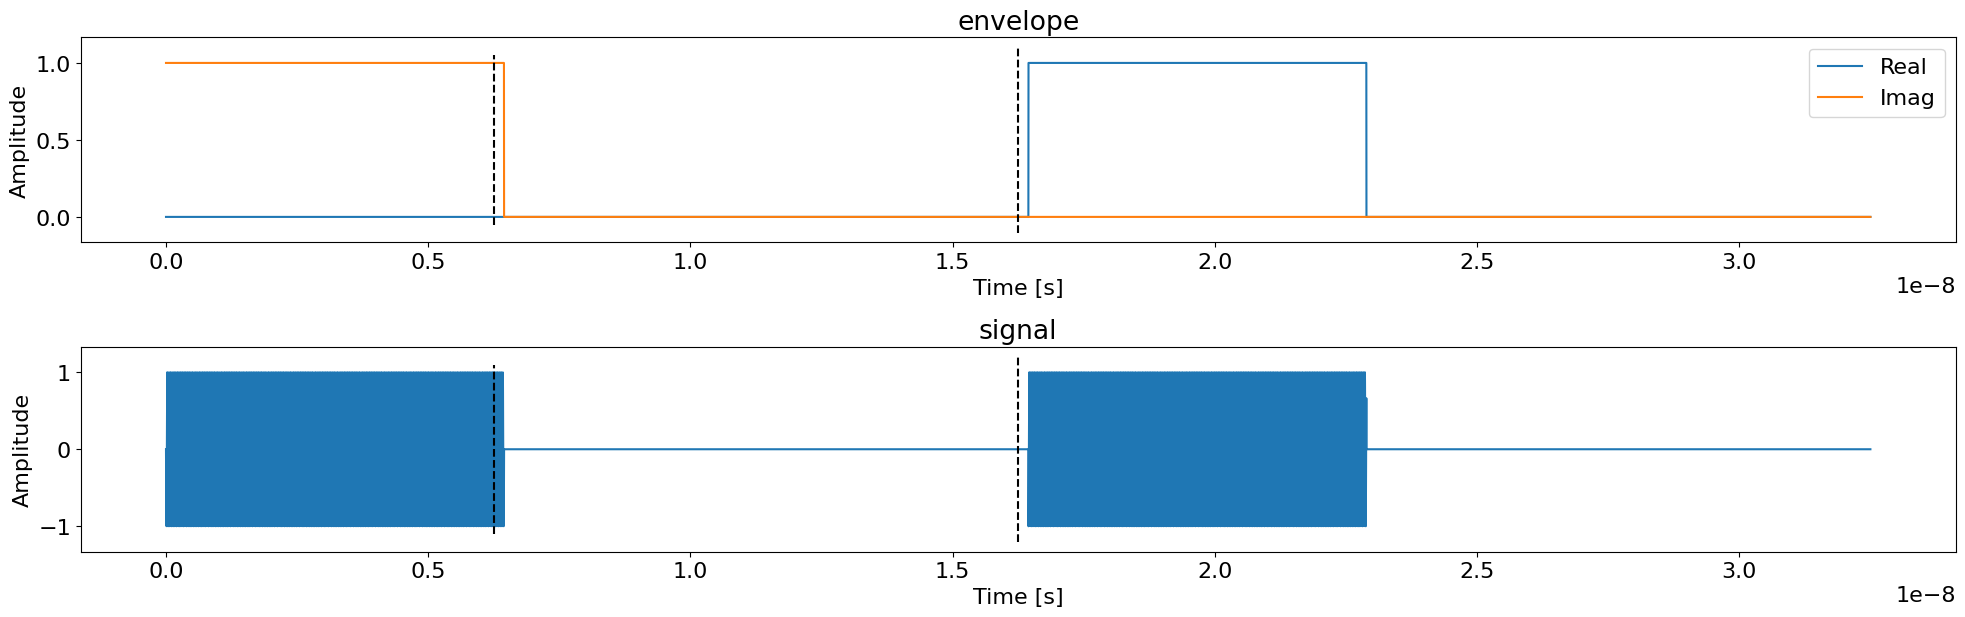

In [48]:
#########################################
# Schedule to signal conversion
#########################################
converter = InstructionToSignals(dt, carriers={"d0": omega})
signal = converter.get_signals(sxp);
signal = signal[0];

#########################################
# Graphics
#########################################
tend = tgate + tidle + tgate + tidle;
fig, axs = plt.subplots(2, 1, figsize=(20, 6))
fig.tight_layout(h_pad=3)
for ax, title in zip(axs, ["envelope", "signal"]):
    signal.draw(0, tend, 50000, title, axis=ax)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Amplitude")
    ax.set_title(title)
    ax.vlines(tgate, ax.get_ylim()[0], ax.get_ylim()[1], "k", linestyle="dashed")
    ax.vlines(tgate+tidle, ax.get_ylim()[0], ax.get_ylim()[1], "k", linestyle="dashed")

tend/dt

### Pulse-compatible Solvers

`Schedule` objects can be fed to a `Backend`, representing an equivalent series of quantum gates. To perform pulse-level simulation of quantum hardware, we need to construct a `DynamicsBackend` object starting from a `Solver` object containing the Hamiltonian. However, we need to add some information to better represent the hardware system. Particularly: 
* `hamiltonian_channels` is a list mapping each of the `hamiltonian_operators` to one drive line
* `channel_carrier_freqs` is a dict containing the carrier frequencies of each drive line
* `dt` is the AWG time resolution. 

In [49]:
#########################################
# Simulation setup
#########################################
omega = 2 * np.pi * 4.95e9;                 # Qubit natural frequency [Hz]
Omega = 2 * np.pi * 20e6;                   # Driving frequency [Hz]

hdrift = 1/2 * omega * Z;                   # Natural Hamiltonian
hdrive = Omega * X;                         # Interaction Hamiltonian

#########################################
# Simulator creation
#########################################
solver = Solver(static_hamiltonian=hdrift, hamiltonian_operators=[hdrive], hamiltonian_channels=["d0"], rotating_frame=hdrift, channel_carrier_freqs={"d0":omega/2/np.pi}, dt=dt);
backend = DynamicsBackend(solver=solver,subsystem_dims=[2]);

### Signal-level simulation

Since we are now moving towards a realistic quantum circuit simulation, we need to also include some measurement at the end of our `Schedule`. In real quantum hardware, measurements require the application of specific pulses to dedicated measurement channels. In the simulation environment, we can encode them in an easier way by appending the `pulse.acquire(duration,channel,creg)` instruction to our `Schedule`, where `duration` is the duration of the measurement, `channel` is the target channel, and `creg` is the classical register index where the measurement will be stored. We can check that, despite the modification of the Hamiltonian we introduced previously, the result is still the same: 

3.25e-08


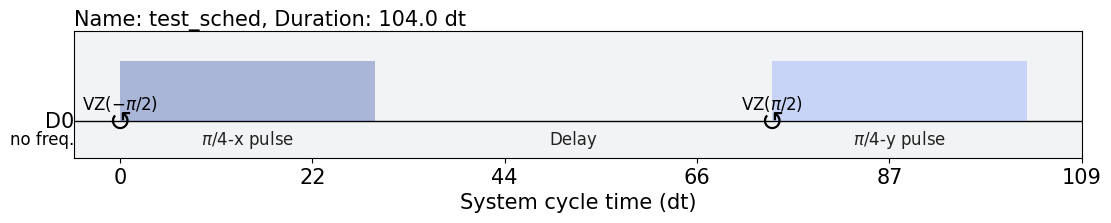

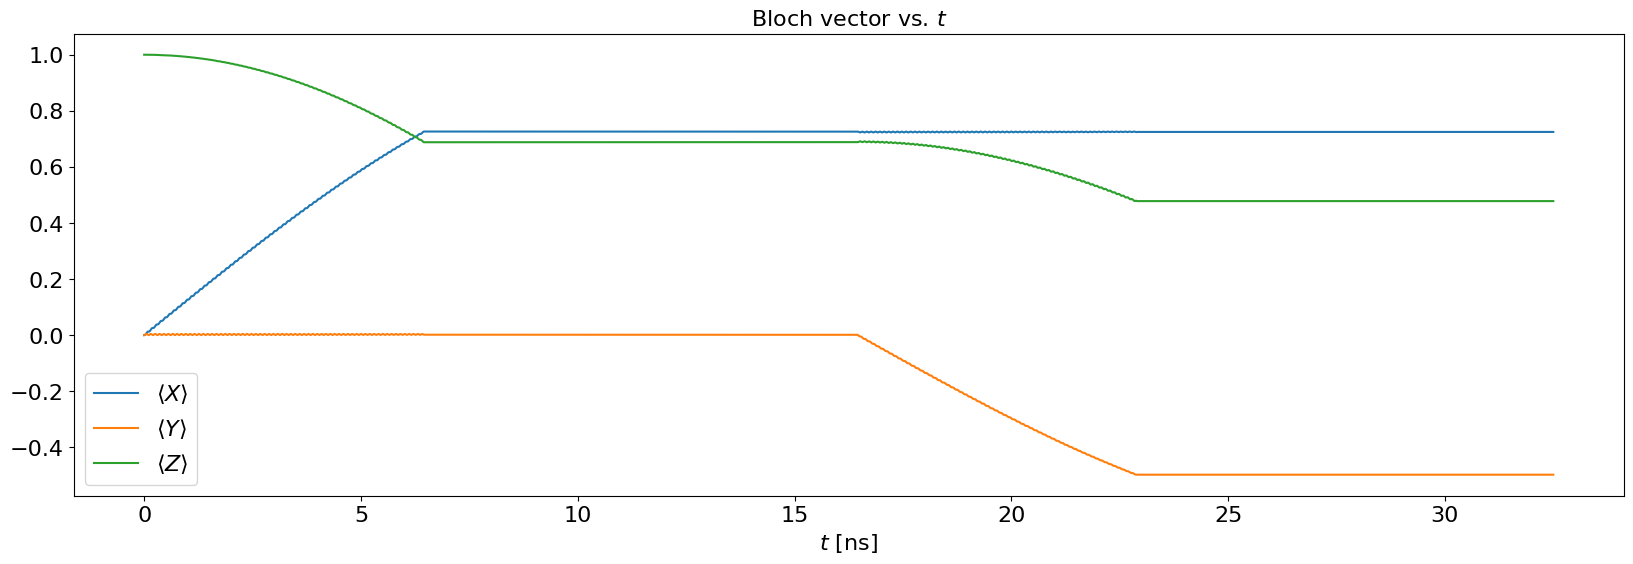

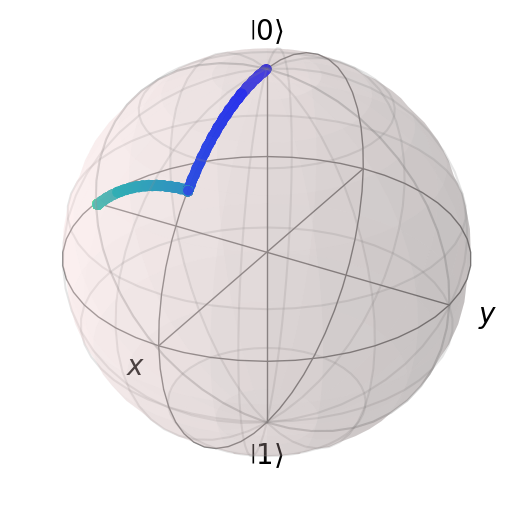

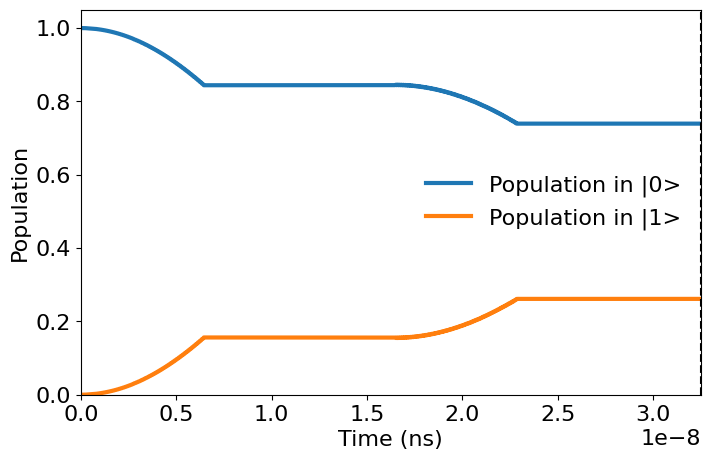

In [51]:
#########################################
# Pulse schedule creation
#########################################
with pulse.build(name="test_sched") as sxp:
    with pulse.align_sequential():
        pulse.shift_phase(np.pi/2, pulse.DriveChannel(0))
        pulse.play(pulse.library.Constant(dgate,1,name="$\pi$/4-x pulse"), pulse.DriveChannel(0))
        pulse.delay(didle,pulse.DriveChannel(0))
        pulse.shift_phase(-np.pi/2, pulse.DriveChannel(0))
        pulse.play(pulse.library.Constant(dgate,1, name="$\pi$/4-y pulse"), pulse.DriveChannel(0))
        pulse.acquire(duration=1, qubit_or_channel=0, register=pulse.MemorySlot(0))

#########################################
# Simulation
#########################################
t_eval = np.linspace(0,tend,50000); 
sol = solver.solve(t_span=[0,tend], y0=y0, signals=sxp, t_eval=t_eval)

#########################################
# Graphics
#########################################
print(tend)
display.display(sxp.draw())
plot_qubit_dynamics(sol,t_eval); 
plot_bloch_traj(sol.y,50); 
plot_populations(sol,tend)

### Pulse-level simulation

We can run our `Schedule` on the `Backend` we built by calling the `.run()` method. Checking the counts for the $|0\rangle$ and $|1\rangle$ state provides us results coherent with the expected state population: 

{'0': 733, '1': 267}

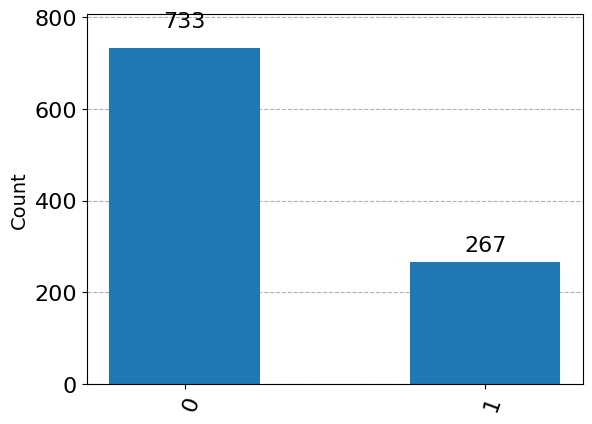

In [52]:
#########################################
# Simulation
#########################################
job = backend.run([sxp], shots=1000, meas_return="single")
result = job.result()
display.display(result.get_counts())

#########################################
# Graphics
#########################################
plot_histogram(result.get_counts())

### Building Schedules from QuantumCircuits

As a last step, let's close the loop towards quantum circuits by checking the pulse schedule of a real `QuantumCircuit`. Let's instantiate a circuit that replicates our sequence of rotations: 

In [54]:
#########################################
# Circuit setup
#########################################
circ = QuantumCircuit(1, 1)
circ.ry(np.pi/4,0)
circ.rx(np.pi/4,0)
circ.measure([0], [0])

#########################################
# Graphics
#########################################
display.display(circ.draw("text"))

┌─────────┐┌─────────┐┌─┐
  q: ┤ Ry(π/4) ├┤ Rx(π/4) ├┤M├
     └─────────┘└─────────┘└╥┘
c: 1/═══════════════════════╩═
                            0

Next, let's compile our circuit for a real backend. We can build the equivalent `Schedule` using the `build_schedule` function: 

In [55]:
from qiskit import transpile, schedule as build_schedule
from qiskit_ibm_runtime import QiskitRuntimeService
#QiskitRuntimeService.save_account(channel="ibm_quantum", token="YOUR_IBM_QUANTUM_TOKEN",overwrite=True);

#########################################
# IBM Backend creation
#########################################
service = QiskitRuntimeService(channel='ibm_quantum')
backend2 = service.least_busy(); 
print(backend2)
print(backend2.operations)

#########################################
# Circuit transpilation
#########################################
transpiled_circ = transpile(circ, backend2)
schedule = build_schedule(transpiled_circ, backend2)
display.display(schedule.filter(channels=[pulse.DriveChannel(0)]).draw())
display.display(transpiled_circ.draw("mpl",idle_wires=False))

ModuleNotFoundError: No module named 'qiskit_ibm_runtime'

Notice how, after the transpilation, the circuit is reduced to a sequence of $z$-rotations (implemented virtually using VZ gates), and $\pi/2$ $x$-rotations, which are instead realized by DRAG pulses. These pulses are calibrated on the hardware, where the calibration refers to the careful optimization of parameters in order to enact the desired rotation, maximizing the so-called gate fidelity.

## Calibrating a Rabi pulse <a class="anchor" id="rabi-pulse"></a>

### Amplitude vs pulse-width modulation

Let us recall the signals associated with the schedule we just used to simulate our sequence of rotations: 

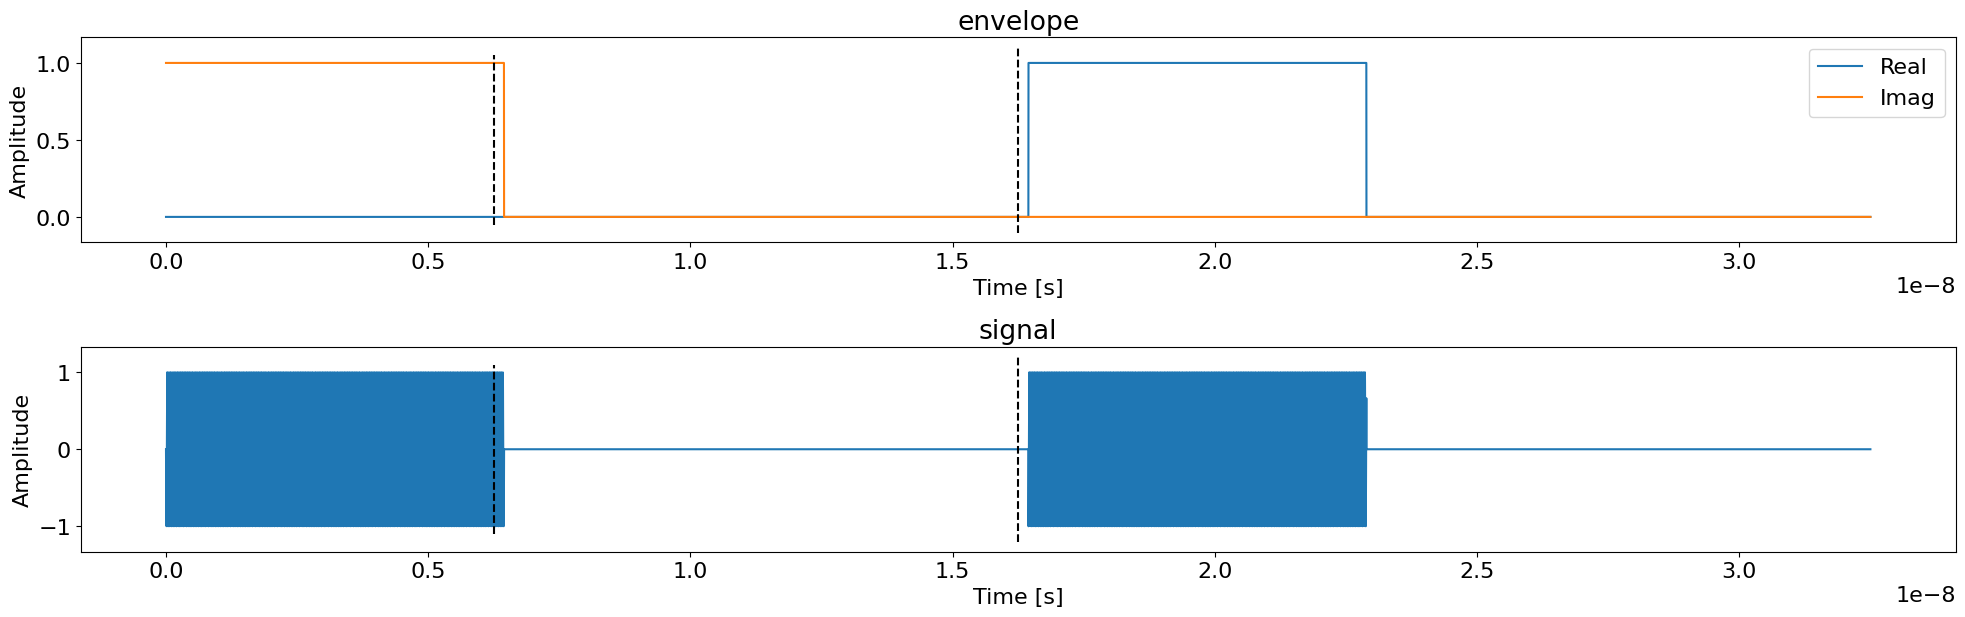

In [56]:
fig, axs = plt.subplots(2, 1, figsize=(20, 6))
fig.tight_layout(h_pad=3)
for ax, title in zip(axs, ["envelope", "signal"]):
    signal.draw(0, tend, 50000, title, axis=ax)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Amplitude")
    ax.set_title(title)
    ax.vlines(tgate, ax.get_ylim()[0], ax.get_ylim()[1], "k", linestyle="dashed")
    ax.vlines(tgate+tidle, ax.get_ylim()[0], ax.get_ylim()[1], "k", linestyle="dashed")

Notice how, despite the relatively high bandwidth of our AWG (4.5 GHz), setting the timestep `dt`, we are unable to match exactly the start and stop time required to properly operate the gate. This leads to small, yet nonzero, rotation errors whose impact accumulates over time as multiple pulses are sent to the circuit. For this reason, the length of pulses is typically chosen to match an integer number of timesteps, thus enabling high precision on the start and end times. Consequently, the time can not be tuned anymore to operate an arbitrary rotation: we must instead act on the driving strength, _i.e._ the Rabi frequency, in order to provide the same rotation angle. The Rabi frequency can be changed by increasing or decreasing the amplitude of the signal envelope: an amplitude of `1` results in a Rabi frequency $\Omega$; an amplitude of $0 \leq \alpha \leq 1$ results in a Rabi frequency $\alpha \Omega$. 

### Parametric Pulse schedules

Let's target the calibration of a $\pi$ pulse. We set the pulse duration to 250 `dt`, and build a series of pulse schedules to investigate the Rabi oscillations of the system, depending on the amplitude of the driving field. We will make use of the `Parameter` class to create a parametric pulse in terms of the drive amplitude, and then create our collection of schedules by populating the parameter. 

In [57]:
#########################################
# Setup
#########################################
num_rabi_points = 50                        # Number of drive amplitudes to test
duration        = 250;                      # Pulse duration [cycles]

drive_amp_min   = 0                         # Minimum drive to test
drive_amp_max   = 1.                        # Maximum drive to test
drive_amps      = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

#########################################
# Parametric Pulse schedule creation
#########################################
drive_amp = Parameter('drive_amp')
with pulse.build() as rabi_sched:
    with pulse.align_sequential():
        pulse.play(pulse.Constant(duration,drive_amp,name="Rabi Pulse"),pulse.DriveChannel(0)); 
        pulse.acquire(1,0,pulse.MemorySlot(0)); 

rabi_schedules = [rabi_sched.assign_parameters({drive_amp: a}, inplace=False) for a in drive_amps]

We run each schedule 100 times to compute a good estimate of $P_0$ and $P_1$. 

In [58]:
#########################################
# Pulse-level simulation
#########################################
num_shots_per_point = 100
job = backend.run(rabi_schedules, 
                  meas_level=2, 
                  meas_return='avg', 
                  shots=num_shots_per_point)
rabi_results = job.result()

We can plot the obtained counts as a function of the drive amplitude, highlighting the Rabi oscillations: 

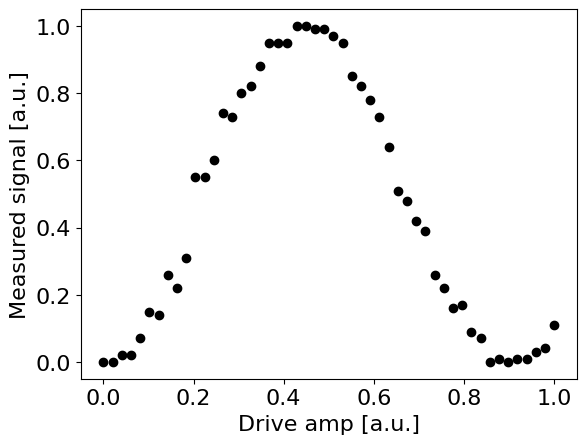

In [59]:
#########################################
# Graphics
#########################################
rabi_values = get_meas_signal(rabi_results,num_rabi_points,num_shots_per_point);
plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values, color='black')
plt.show()

### π-pulse amplitude estimation

Let's fit this waveform with a cosine: 

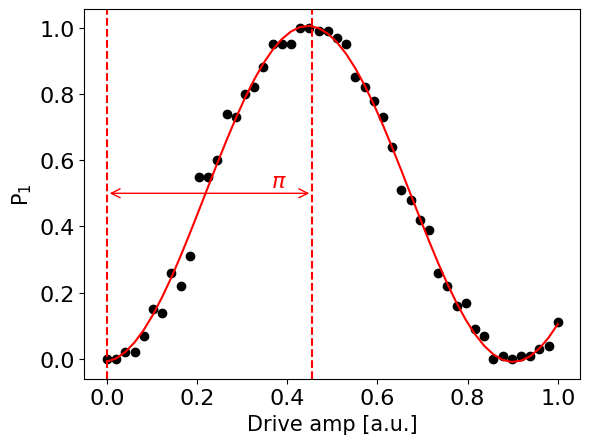

Pi Amplitude = 0.45497685727151127


In [60]:
#########################################
# Curve fitting
#########################################
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.sin(2*np.pi*x/drive_period - phi) + B),
                                 [0.5, -0.5, 0.9, 0])

drive_period    = fit_params[2]
pi_amp          = abs(drive_period / 2)

#########################################
# Graphics
#########################################
plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')

plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(0, color='red', linestyle='--')
plt.annotate("", xy=(0, 0.5), xytext=(drive_period/2,0.5), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period*.4, 0.52), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("P$_1$", fontsize=15)
plt.show()

print(f"Pi Amplitude = {pi_amp}")

We can verify that a pulse with this amplitude enacts a $\pi$ rotation of the qubit: 

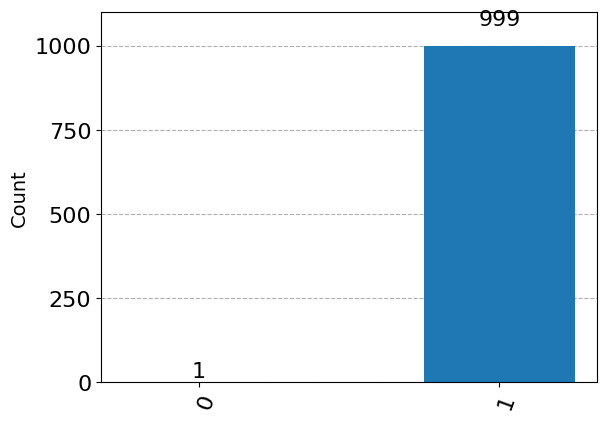

In [61]:
#########################################
# Pi-Pulse schedule creation
#########################################
with pulse.build() as rabi_pi:
    with pulse.align_sequential():
        pulse.play(pulse.Constant(duration,pi_amp,name="Rabi $\pi$-Pulse"),pulse.DriveChannel(0)); 
        pulse.acquire(1,0,pulse.MemorySlot(0)); 
rabi_pi.draw()

#########################################
# Pulse-level simulation
#########################################
job = backend.run(rabi_pi, 
                  meas_level=2, 
                  meas_return='avg', 
                  shots=1000)
result = job.result()
result.get_counts(0)
plot_histogram(result.get_counts())

Similarly, a pulse with half the amplitude enacts a $\pi/2$ rotation of the qubit: 

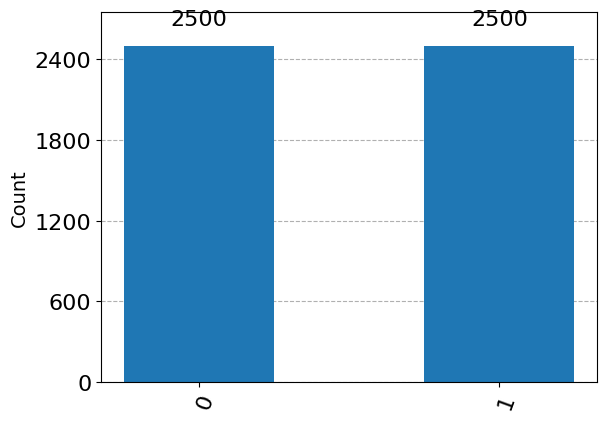

In [62]:
#########################################
# Pi/2-Pulse schedule creation
#########################################
with pulse.build() as rabi_pi:
    with pulse.align_sequential():
        pulse.play(pulse.Constant(duration,pi_amp/2,name="Rabi $\pi/2$-Pulse"),pulse.DriveChannel(0)); 
        pulse.acquire(1,0,pulse.MemorySlot(0)); 
rabi_pi.draw()

#########################################
# Pulse-level simulation
#########################################
job = backend.run(rabi_pi, 
                  meas_level=2, 
                  meas_return='avg', 
                  shots=5000)
result = job.result()
result.get_counts(0)
plot_histogram(result.get_counts())

Finally, let us check the schedule result for our usual $\pi/4$ $y-x$ rotation. 

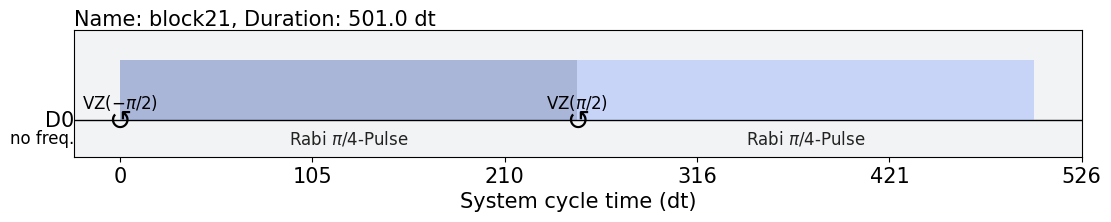

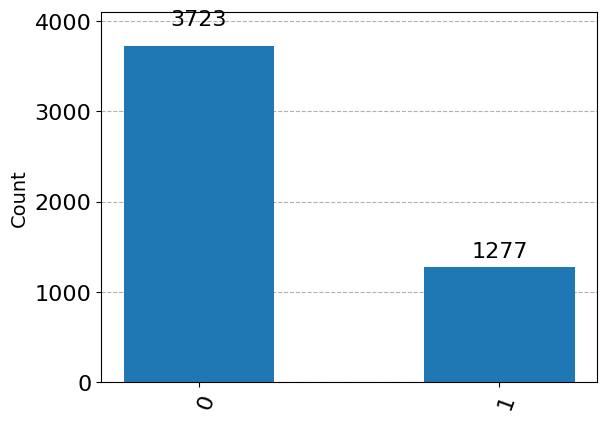

P0 = 0.74 (counts = 3723)
P1 = 0.26 (counts = 1277)


In [63]:
#########################################
# Pi/4-Pulse xy schedule creation
#########################################
duration = 250;                   
with pulse.build() as rabi_yx:
    with pulse.align_sequential():
        pulse.shift_phase(np.pi/2,pulse.DriveChannel(0));
        pulse.play(pulse.Constant(duration,pi_amp/4,name="Rabi $\pi/4$-Pulse"),pulse.DriveChannel(0)); 
        pulse.shift_phase(-np.pi/2,pulse.DriveChannel(0));
        pulse.play(pulse.Constant(duration,pi_amp/4,name="Rabi $\pi/4$-Pulse"),pulse.DriveChannel(0)); 
        pulse.acquire(1,0,pulse.MemorySlot(0)); 
display.display(rabi_yx.draw())

#########################################
# Pulse-level simulation
#########################################
job = backend.run(rabi_yx, 
                  meas_level=2, 
                  meas_return='avg', 
                  shots=5000)
result = job.result()
counts = result.get_counts(0)
display.display(plot_histogram(result.get_counts()))

print(f"P0 = {counts['0']/5000:.2f} (counts = {counts['0']})")
print(f"P1 = {counts['1']/5000:.2f} (counts = {counts['1']})")

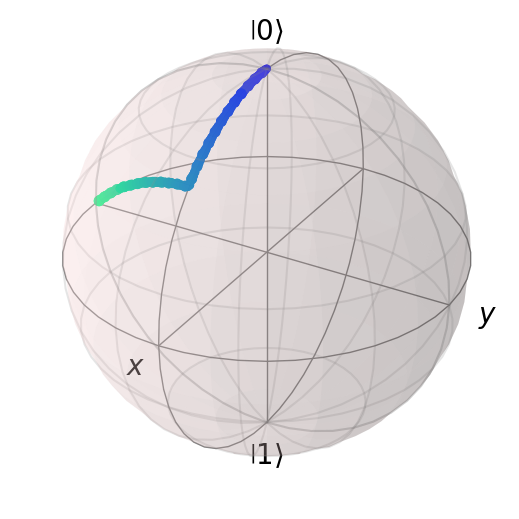

In [64]:
#########################################
# Signal-level simulation
#########################################
tend    = 2*duration*dt; 
t_eval  = np.linspace(0,tend,100); 
sol     = solver.solve(t_span=[0,tend],y0=y0,signals=rabi_yx,t_eval=t_eval)

plot_bloch_traj(sol.y); 
#video_bloch_traj(sol.y,10); 

## Detuning <a class="anchor" id="detuning"></a>

Up to here, we have always considered the drive field to be perfectly tuned to the qubit frequency. However, this is typically not the case for a first-time setup: while the qubit frequency can be estimated from its design parameters, variability in the fabrication process can lead to slight deviations from the nominal values. As a consequence of this _detuning_, the rotating frame underneath the qubit is evolving at a slightly different frequency with respect to the qubit's precession, leading to spurious $z$-rotation. Let's consider a quantum system with our usual 4.95 GHz qubit, a driving field strength of 20 MHz, and a detuning of 5 MHz (_i.e._ a frequency of the driving field of 4.955 GHz).

In [65]:
#########################################
# System setup
#########################################
w   = 2 * np.pi * 4.95e9;                   # Qubit natural frequency [Hz] 
wd  = 2 * np.pi * 4.955e9;                  # Driving frequency [Hz]
R   = 2 * np.pi * 20e6;                     # Driving field strength [Hz]

dt  = 1/4.5e9;                              # AWG resolution [s]

hdrift = 1/2 * w * Z;                       # Natural Hamiltonian
hdrive = R * X;                             # Driving Hamiltonian
hframe = 1/2 * wd * Z;                      # Rotating frame Hamiltonian

solver = Solver(static_hamiltonian=hdrift, hamiltonian_operators=[hdrive], hamiltonian_channels=["d0"], rotating_frame=hframe, channel_carrier_freqs={"d0":wd/2/np.pi}, dt=dt)
backend = DynamicsBackend(solver=solver);

Let us consider a sequence of two $\pi/4$ pulses around the $x$-axis and the $y$-axis. Since we have not changed the driving strength, we can reuse the same amplitude value we just calibrated: 

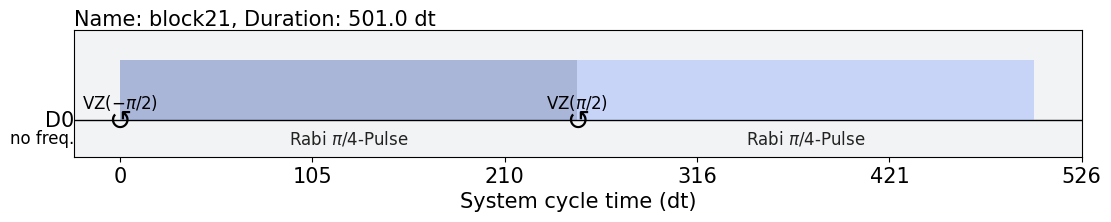

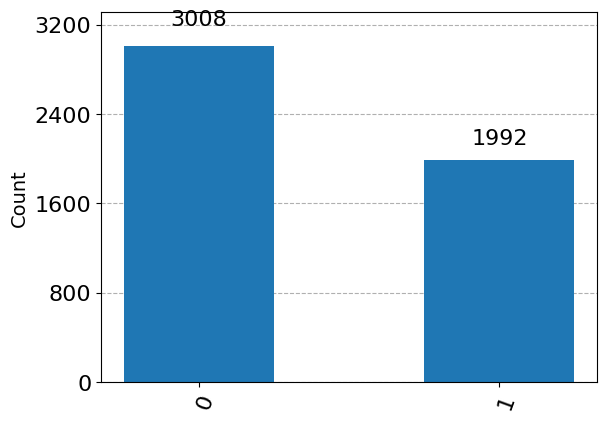

P0 = 0.60 (counts = 3008)
P1 = 0.40 (counts = 1992)


In [66]:
#########################################
# Pulse-level simulation
#########################################
job = backend.run(rabi_yx, 
                  meas_level=2, 
                  meas_return='avg', 
                  shots=5000)
result = job.result()
counts = result.get_counts(0)

#########################################
# Graphics
#########################################
display.display(rabi_yx.draw())
display.display(plot_histogram(result.get_counts()))
print(f"P0 = {counts['0']/5000:.2f} (counts = {counts['0']})")
print(f"P1 = {counts['1']/5000:.2f} (counts = {counts['1']})")

Notice that now the results are completely different! An inspection of the state population can give us more insight into what's happening.

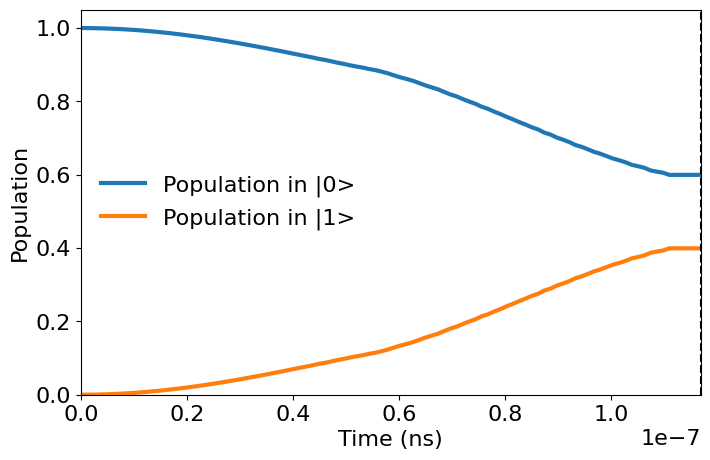

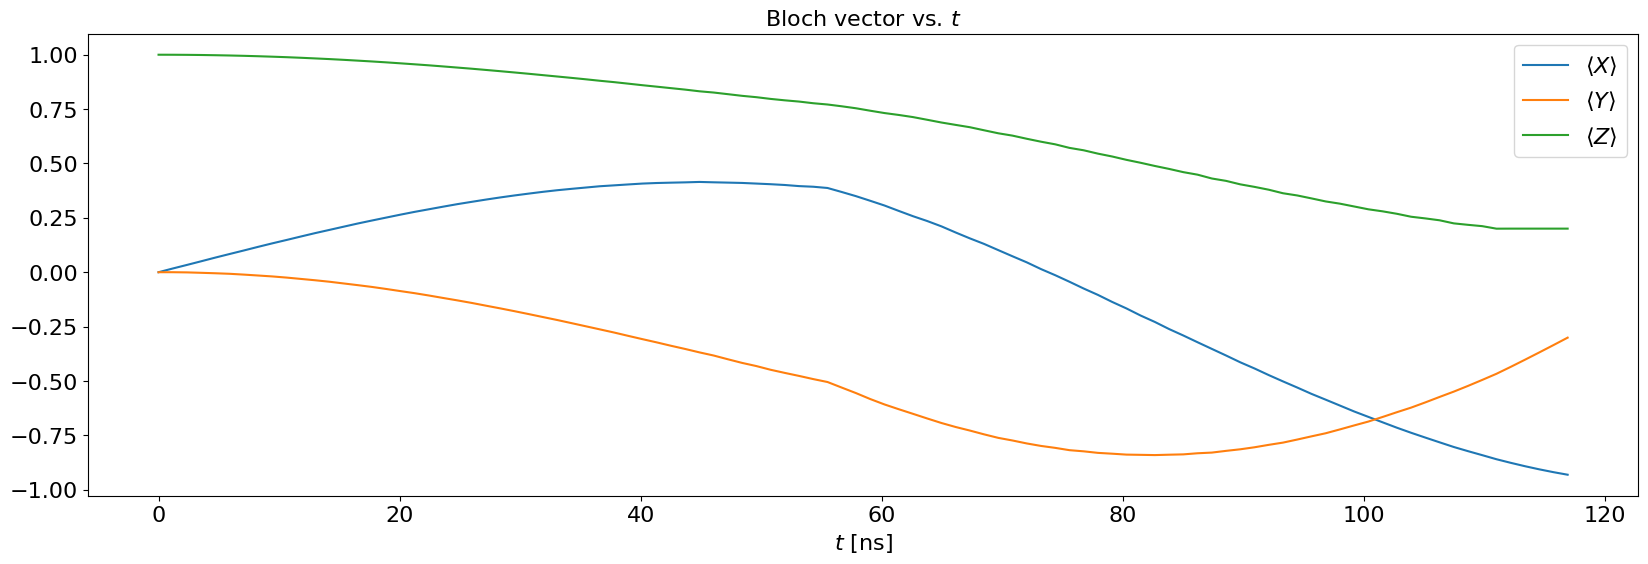

In [67]:
#########################################
# Signal-level simulation
#########################################
tend = 526*dt;
t_eval = np.linspace(0,tend,100); 
sfull = Solver(static_hamiltonian=hdrift, hamiltonian_operators=[hdrive], hamiltonian_channels=["d0"], rotating_frame=hframe, channel_carrier_freqs={"d0":wd/2/np.pi}, dt=dt)
sol = sfull.solve(t_span=[0,tend], y0=y0, signals=rabi_yx, t_eval=t_eval)

#########################################
# Graphics
#########################################
plot_populations(sol,tend)
plot_qubit_dynamics(sol,t_eval)

Due to the field being off-resonance with the qubit, we are no longer enacting the same sequence of rotations on the qubit: 

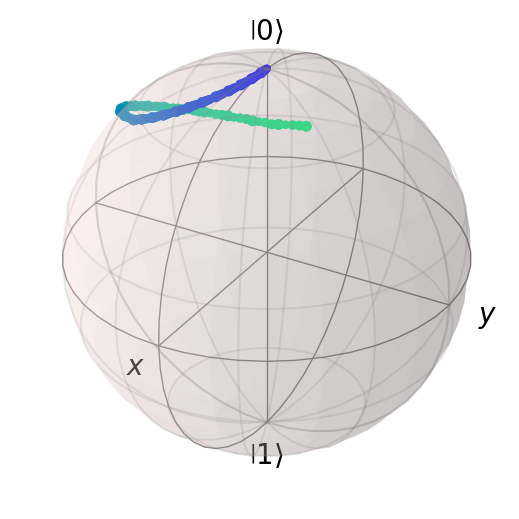

In [68]:
plot_bloch_traj(sol.y);

How can we correct the driving frequency and eliminate detuning? We'll see in next laboratory, dealing with quantum system characterization. 